In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [179]:
tf.random.set_seed(123)
data = pd.read_excel("CONSUMO-2024-05.xlsx", index_col="Fecha", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

consume_data = data['Gasolina superior'].to_frame()
consume_data
print(type(consume_data))

<class 'pandas.core.frame.DataFrame'>


In [180]:
import matplotlib.dates as mdates

# Assuming consume_data is already loaded

# Ensure the index is a DatetimeIndex
if not isinstance(consume_data.index, pd.DatetimeIndex):
    consume_data.index = pd.to_datetime(consume_data.index)

# Group the data by year and sum the values
consume_data_yearly = consume_data.resample('Y').sum()

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_21096/2137812748.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  consume_data_yearly = consume_data.resample('Y').sum()


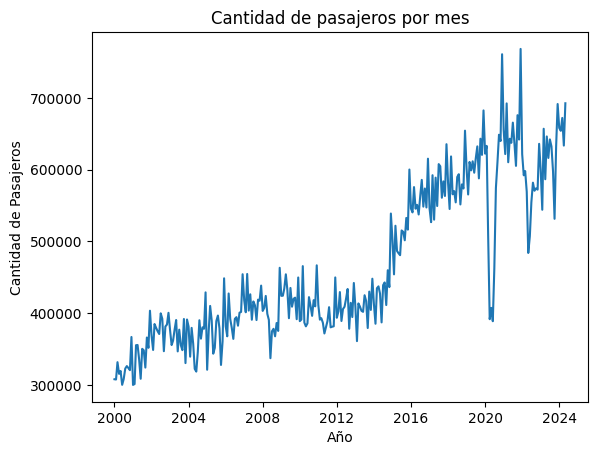

In [181]:
plt.plot(consume_data)
plt.gca().set(title="Cantidad de pasajeros por mes", xlabel="Año", ylabel="Cantidad de Pasajeros")
plt.show()

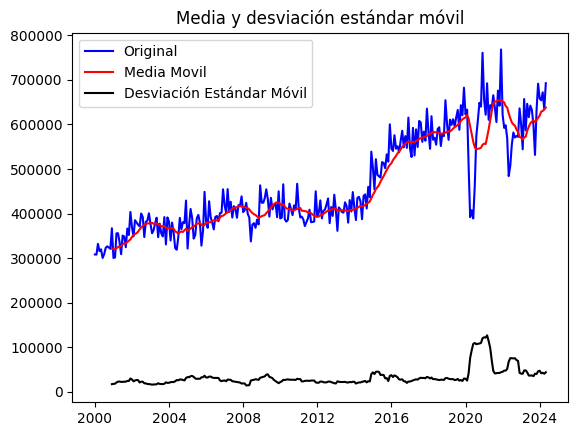

In [182]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = consume_data.rolling(window=12).mean()
deMovil = consume_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(consume_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

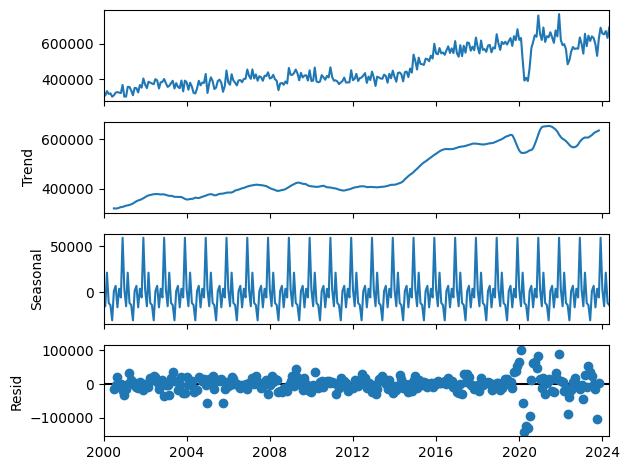

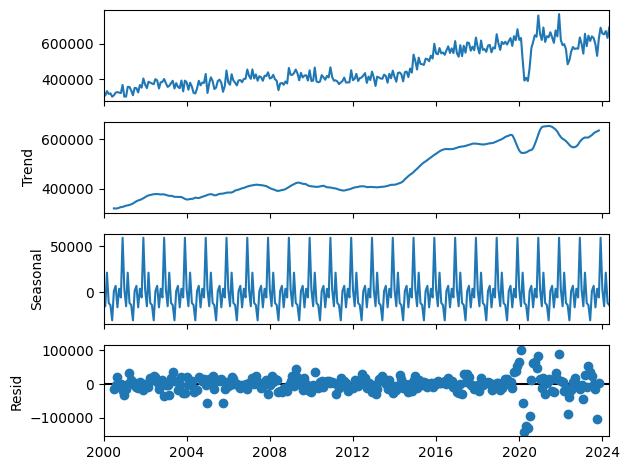

In [183]:
descomposicion = seasonal_decompose(consume_data, model='additive', period=12)
descomposicion.plot()

In [184]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consume_data, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.678783
p-value                        0.852169
# de retardos usados          12.000000
# de observaciones usadas    280.000000
Critical Value (1%)           -3.453922
Critical Value (5%)           -2.871918
Critical Value (10%)          -2.572300
dtype: float64


In [185]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
consume_data_diff = consume_data.diff()
consume_data_diff.fillna(0,inplace=True)
dfTest = adfuller(consume_data_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.675884
p-value                        0.000093
# de retardos usados          16.000000
# de observaciones usadas    276.000000
Critical Value (1%)           -3.454267
Critical Value (5%)           -2.872070
Critical Value (10%)          -2.572381
dtype: float64


In [186]:
scaler = StandardScaler()
consume_data_scaled = scaler.fit_transform(consume_data_diff) 
consume_data_scaled[1:7]


array([[-0.04017635],
       [ 0.53896422],
       [-0.41483037],
       [ 0.06393185],
       [-0.48701636],
       [ 0.156897  ]])

In [187]:
entrenamiento = round(0.6*len(consume_data_scaled))
val_prueba = round(0.2*len(consume_data_scaled))
test = consume_data_scaled[(entrenamiento+val_prueba)-1:]
validation = consume_data_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = consume_data_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

59

In [188]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [189]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

In [190]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

In [191]:
from keras import regularizers

modelo1 = Sequential()

inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
outputs = keras.layers.Dense(2)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

In [192]:
modelo2 = Sequential()

inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote, activation='tanh', kernel_regularizer=regularizers.l1_l2(0.001))(inputs)
outputs = keras.layers.Dense(4)(lstm_out)

modelo2 = keras.Model(inputs=inputs, outputs=outputs)
modelo2.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

In [193]:
modelo1.compile(loss='mean_squared_error',optimizer="adam")
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [194]:
epocas = 100
history1 = modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

history2 = modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = True,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5622 - val_loss: 1.0353
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 0.5537 - val_loss: 1.0236
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.5497 - val_loss: 1.0168
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.5474 - val_loss: 1.0125
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.5459 - val_loss: 1.0095
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.5449 - val_loss: 1.0075
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 0.5441 - val_loss: 1.0060
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.5435 - val_loss: 1.0050
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.5430 - val_loss: 1.0043
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.5427 - val_loss: 1.0038
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.5424 - val_loss: 1.0034
Epoch 12/100
176/176 

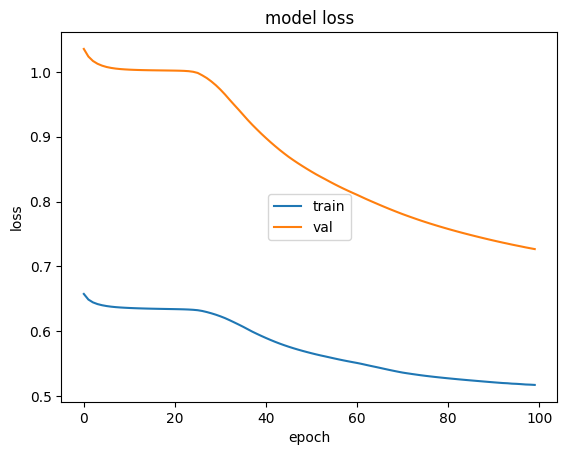

In [195]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

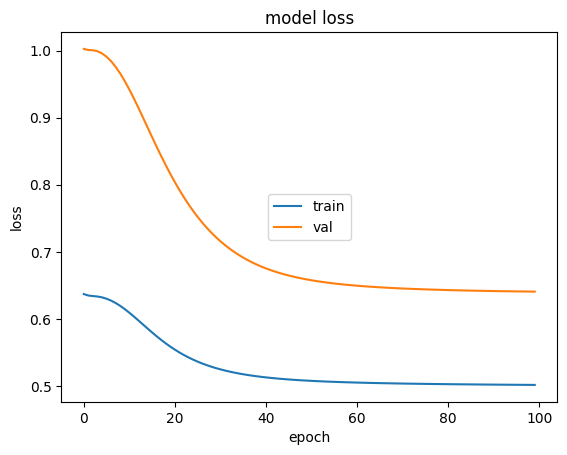

In [196]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [197]:
medianLoss1 = np.median(history1.history['val_loss'])
medianLoss2 = np.median(history2.history['val_loss'])

modelo = modelo1

if medianLoss1 < medianLoss2:
    print("El modelo 1 es mejor")
else:
    print("El modelo 2 es mejor")
    modelo = modelo2

El modelo 2 es mejor


In [198]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
            # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


In [199]:
prediccion_val = prediccion_fun(x_val,modelo, 1,scaler,dif=True,dif_cant=1, Series = consume_data.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo, 1,scaler,dif=True,dif_cant=1, Series = consume_data.values , n=entrenamiento+val_prueba)

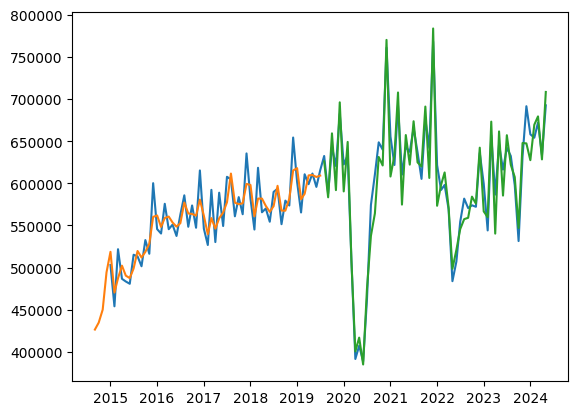

In [209]:
df_val = pd.DataFrame(prediccion_val,index=consume_data[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=consume_data[entrenamiento+len(df_val):len(consume_data)].index)

plt.plot(consume_data['2015':])
plt.plot(df_val)
plt.plot(df_test)

In [201]:
# Calculate metrics for validation predictions
mae_val = mean_absolute_error(consume_data[entrenamiento:entrenamiento+val_prueba], prediccion_val)
mse_val = mean_squared_error(consume_data[entrenamiento:entrenamiento+val_prueba], prediccion_val)
r2_val = r2_score(consume_data[entrenamiento:entrenamiento+val_prueba], prediccion_val)

# Calculate metrics for test predictions
mae_test = mean_absolute_error(consume_data[entrenamiento+len(df_val):len(consume_data)], prediccion_test)
mse_test = mean_squared_error(consume_data[entrenamiento+len(df_val):len(consume_data)], prediccion_test)
r2_test = r2_score(consume_data[entrenamiento+len(df_val):len(consume_data)], prediccion_test)

# Print the results
print(f"Validation MAE: {mae_val}, MSE: {mse_val}, R²: {r2_val}")
print(f"Test MAE: {mae_test}, MSE: {mse_test}, R²: {r2_test}")

Validation MAE: 16450.247912390758, MSE: 370708766.02698535, R²: 0.8446248907152245
Test MAE: 17708.02178639379, MSE: 462750248.44735074, R²: 0.9173724614887587
